# **Art Painting Recognition System**

## 1. Necessary Library and Module Imports

#### Import essential libraries for data manipulation, deep learning, image processing, and GUI

In [ ]:
import os
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import filedialog, messagebox

# Keras imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Paths & parameters
CSV_PATH = r"C:\Users\ayush\OneDrive\Desktop\ML Mini Project\artists.csv"
DATA_DIR = r"C:\Users\ayush\OneDrive\Desktop\ML Mini Project\resized\resized"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 39

INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

## 2. Data Loading and Preprocessing

#### Load artist metadata from CSV and set up data generators for training and validation which perform real-time data augmentation during training

In [ ]:
# Load CSV metadata
artists_df = pd.read_csv(CSV_PATH)
print(f"Total artists in CSV: {len(artists_df)}")

#verify folder structure
folder_artists = set(os.listdir(DATA_DIR))
csv_artists = set(artists_df['name'])
if folder_artists != csv_artists:
    print("Warning: Folder structure doesn't match CSV entries")
    print("Missing folders:", csv_artists - folder_artists)
else:
    print("✅ Folder structure verified")

# Training the model
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Total artists in CSV: 50
Missing folders: {'Jackson Pollock', 'Michelangelo', 'Georges Seurat', 'Eugene Delacroix', 'Titian', 'Raphael', 'Paul Cezanne', 'Albrecht Dürer', 'Diego Velazquez', 'Rembrandt', 'Caravaggio'}
Found 5709 images belonging to 39 classes.
Found 1405 images belonging to 39 classes.


## 3. Model Architecture (Feature layering and extraction)

In [3]:
def create_model():
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 39)             │        10,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,595,943 (9.90 MB)

 Trainable params: 337,959 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Training and Evaluation

#### Set up callbacks for training optimization

In [4]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,  # 10
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


c:\Users\ayush\OneDrive\Desktop\ML Mini Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.2314 - loss: 3.0855 - val_accuracy: 0.4754 - val_loss: 1.9937 - learning_rate: 0.0010
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 165s 921ms/step - accuracy: 0.4470 - loss: 2.0098 - val_accuracy: 0.5196 - val_loss: 1.7366 - learning_rate: 0.0010
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.5337 - loss: 1.6479 - val_accuracy: 0.5495 - val_loss: 1.6459 - learning_rate: 0.0010
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 177s 989ms/step - accuracy: 0.5772 - loss: 1.4643 - val_accuracy: 0.5765 - val_loss: 1.5312 - learning_rate: 0.0010
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.6253 - loss: 1.3142 - val_accuracy: 0.5886 - val_loss: 1.4540 - learning_rate: 0.0010
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 160s 891ms/step - accuracy: 0.6337 - loss: 1.2589 - val_accuracy: 0.6021 - val_loss: 1.4387 - learning_rate: 0.0010
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 153s 855ms/step - accuracy: 0.651

## 5. Final Model Performance

#### This section evaluates the best model and prints the final validation accuracy and loss.

In [5]:
base_model = model.layers[1]  # The MobileNetV2 model
unfreeze_layers = int(len(base_model.layers) * 0.2)
for layer in base_model.layers[-unfreeze_layers:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,        # 20 total
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

model.save('artist_recognition_model.keras')

Epoch 10/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 168s 899ms/step - accuracy: 0.7134 - loss: 0.9788 - val_accuracy: 0.6100 - val_loss: 1.3631 - learning_rate: 1.0000e-05
Epoch 11/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 159s 885ms/step - accuracy: 0.7257 - loss: 0.9320 - val_accuracy: 0.6356 - val_loss: 1.3102 - learning_rate: 1.0000e-05
Epoch 12/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 158s 881ms/step - accuracy: 0.7314 - loss: 0.8891 - val_accuracy: 0.6399 - val_loss: 1.3033 - learning_rate: 1.0000e-05
Epoch 13/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 158s 882ms/step - accuracy: 0.7390 - loss: 0.8409 - val_accuracy: 0.6463 - val_loss: 1.3045 - learning_rate: 1.0000e-05
Epoch 14/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.7505 - loss: 0.8364
Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
179/179 ━━━━━━━━━━━━━━━━━━━━ 159s 885ms/step - accuracy: 0.7505 - loss: 0.8363 - val_accuracy: 0.6228 - val_loss: 1.3419 - learning_rate: 1.0000e-05
Epoch 15/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 

## 6. Plot Training History

#### This section defines a function to plot the training and validation accuracy and loss over epochs.

44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 740ms/step - accuracy: 0.6563 - loss: 1.2809

Final Model Performance:
- Validation Accuracy: 65.55%
- Validation Loss: 1.2613


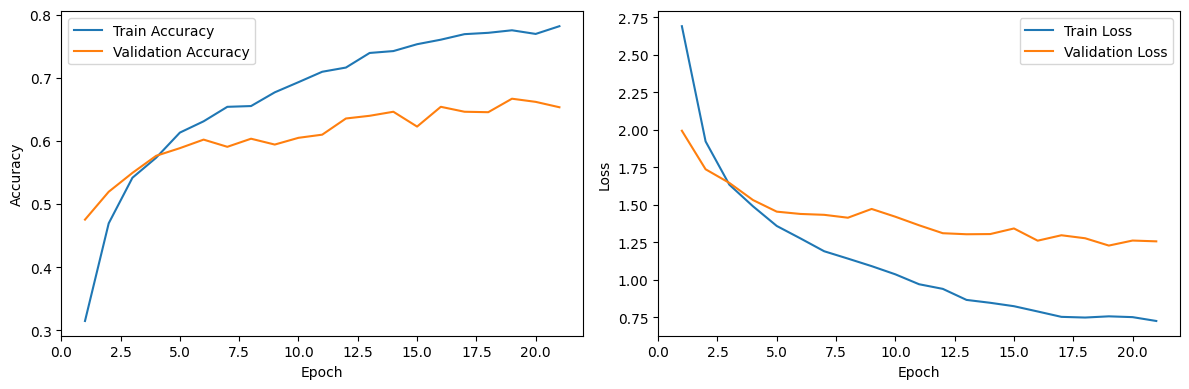

In [6]:
best_model = load_model('best_model.keras')
loss, accuracy = best_model.evaluate(val_generator)
print(f"\nFinal Model Performance:")
print(f"- Validation Accuracy: {accuracy*100:.2f}%")
print(f"- Validation Loss: {loss:.4f}")

def plot_training_history(histories):
    acc = histories[0].history['accuracy'] + histories[1].history.get('accuracy', [])
    val_acc = histories[0].history['val_accuracy'] + histories[1].history.get('val_accuracy', [])
    loss_vals = histories[0].history['loss'] + histories[1].history.get('loss', [])
    val_loss_vals = histories[0].history['val_loss'] + histories[1].history.get('val_loss', [])
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss_vals, label='Train Loss')
    plt.plot(epochs_range, val_loss_vals, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history([history, history_fine])


## 7. Advanced Art Analyzer Class

#### This section defines a class for analyzing art images, including methods for loading images and analyzing them.

In [7]:
class AdvancedArtAnalyzer:
    def __init__(self, model_path, csv_path, dataset_dir):
        self.model = load_model(model_path)
        self.artists_df = pd.read_csv(csv_path)
        self.dataset_dir = os.path.abspath(dataset_dir)

        self.class_indices = train_generator.class_indices
        self.index_to_artist = {v: k for k, v in self.class_indices.items()}

        self.metadata = {}
        for _, row in self.artists_df.iterrows():
            artist = row['name']
            self.metadata[artist] = {
                'genre': row['genre'],
                'nationality': row['nationality'],
                'bio': row['bio']
            }

        self.genre_to_indices = {}
        for artist, idx in self.class_indices.items():
            genre = self.metadata[artist]['genre']
            self.genre_to_indices.setdefault(genre, []).append(idx)

    def load_image_any_path(self, path):
        """Load an image from a local path or a web URL."""
        if path.startswith('http://') or path.startswith('https://'):
            import requests
            from io import BytesIO
            response = requests.get(path)
            response.raise_for_status()
            image_data = BytesIO(response.content)
            pil_img = Image.open(image_data).convert('RGB')
        else:
            pil_img = Image.open(path).convert('RGB')
        return pil_img

    def analyze_image(self, path):
        pil_img = self.load_image_any_path(path)
        pil_img = pil_img.resize(IMG_SIZE)
        img_array = img_to_array(pil_img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        preds = self.model.predict(img_array)[0]

        abs_path = os.path.abspath(path)
        if abs_path.startswith(self.dataset_dir):
            predicted_index = np.argmax(preds)
            predicted_artist = self.index_to_artist[predicted_index]
            confidence = preds[predicted_index] * 100
            meta = self.metadata[predicted_artist]
            return {
                'pil_img': pil_img,
                'artist': predicted_artist,
                'genre': meta['genre'],
                'nationality': meta['nationality'],
                'confidence': f"{confidence:.1f}%",
                'bio': meta['bio'][:200] + '...'
            }
        else:
            genre_scores = {}
            for genre, indices in self.genre_to_indices.items():
                genre_scores[genre] = sum(preds[i] for i in indices)
            predicted_genre = max(genre_scores, key=genre_scores.get)
            confidence = genre_scores[predicted_genre] * 100
            return {
                'pil_img': pil_img,
                'genre': predicted_genre,
                'confidence': f"{confidence:.1f}%"
            }


## 8. Launch GUI Function

#### This section defines a function to launch a graphical user interface for the art recognition system.

In [11]:
def launch_gui():
    analyzer = AdvancedArtAnalyzer('best_model.keras', CSV_PATH, DATA_DIR)

    root = tk.Tk()
    root.title("Beautiful Art Recognition System (Local + URL)")
    root.geometry("800x600")

    
    title_label = tk.Label(root, text="Art Recognition System", font=("Arial", 16, "bold"))
    title_label.pack(pady=10)

    
    info_label = tk.Label(root, text="Paste a local path or web URL to an image, or browse a local file.\nThen click 'Analyze Painting'.",
                          font=("Arial", 11), wraplength=700)
    info_label.pack(pady=5)

    
    # Path Frame
    path_frame = tk.Frame(root)
    path_frame.pack(pady=5)

    path_label = tk.Label(path_frame, text="Image Path/URL:", font=("Arial", 10))
    path_label.pack(side="left", padx=5)

    path_var = tk.StringVar()
    path_entry = tk.Entry(path_frame, textvariable=path_var, width=60, font=("Arial", 10))
    path_entry.pack(side="left", padx=5)

    def browse_file():
        filename = filedialog.askopenfilename(title="Select an Image")
        if filename:
            path_var.set(filename)

    browse_btn = tk.Button(path_frame, text="Browse", command=browse_file,
                           bg="#2196F3", fg="white", font=("Arial", 10))
    browse_btn.pack(side="left")

    image_label = tk.Label(root, bg="white")
    image_label.pack(pady=10)

    result_text = tk.Text(root, height=10, width=80, font=("Arial", 10), wrap="word")
    result_text.pack(pady=10)

    def analyze_painting():
        path = path_var.get().strip()
        if not path:
            messagebox.showerror("Error", "Please enter or select an image path/URL.")
            return
        try:
            results = analyzer.analyze_image(path)

            
            result_text.delete("1.0", tk.END)

            
            pil_img = results['pil_img']
            
            disp_img = pil_img.copy()
            disp_img.thumbnail((300, 300))
            tk_img = ImageTk.PhotoImage(disp_img)
            image_label.config(image=tk_img)
            image_label.image = tk_img

           
            if 'artist' in results:
               
                output = (f"Artist: {results['artist']}\n"
                          f"Nationality: {results['nationality']}\n"
                          f"Genre: {results['genre']}\n"
                          f"Confidence: {results['confidence']}\n"
                          f"Bio: {results['bio']}")
            else:
                output = (f"Predicted Genre: {results['genre']}\n"
                          f"Confidence: {results['confidence']}")

            result_text.insert(tk.END, output)

        except Exception as e:
            messagebox.showerror("Error", f"Failed to analyze image:\n{e}")

    btn_frame = tk.Frame(root)
    btn_frame.pack(pady=10)

    analyze_btn = tk.Button(btn_frame, text="Analyze Painting", command=analyze_painting,
                            bg="#4CAF50", fg="white", font=("Arial", 12), padx=10, pady=5)
    analyze_btn.pack(side="left", padx=5)

    def exit_app():
        root.destroy()

    exit_btn = tk.Button(btn_frame, text="Exit", command=exit_app,
                         bg="red", fg="white", font=("Arial", 12), padx=10, pady=5)
    exit_btn.pack(side="left", padx=5)

    root.mainloop()


if __name__ == "__main__":
     launch_gui()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
